# data prepare

In [2]:
import pandas as pd
from PIL import Image
import torch

In [170]:
data

NameError: name 'data' is not defined

In [2]:
data = pd.read_csv('./data/list_attr_celeba.txt', sep="\s*", header=0)
partition = pd.read_csv('./data/list_eval_partition.txt', sep="\s*", header=None)

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
partition.columns = ["filename", "file_cate"]
data = data.merge(partition, on = "filename", how = "left")

In [4]:
print(data.columns)

Index(['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'file_cate'],
      dtype='object')


In [5]:
data.to_csv("./data/list_merge_attr_celeba.csv", index = False)

In [6]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')#将图片转换为RGB格式。

In [7]:
picture_data1=pil_loader(r'/home/tongqing.li/qianbao/picture_score/data/img_align_celeba/000001.jpg')

In [8]:
import numpy as np
np.array(picture_data1).shape

(218, 178, 3)

In [11]:
from torch.utils.data import Dataset, DataLoader 
import os
class myDataset(Dataset):
    def __init__(self, loadPath, transform, data_category = 0): #r'home/tongqing.li/lesson/pytorch/MNIST_data/MNIST/processed/training.pt'
        super(myDataset, self).__init__()
        self.data = pd.read_csv(loadPath)
        self.data = self.data[self.data["file_cate"] == data_category]
        self.transform = transform
        
    def __getitem__(self, index):
        #Heavy_Makeup，Male，Wearing_Earrings，Wearing_Necklace，Wearing_Necktie
        picture = pil_loader(r'/home/tongqing.li/qianbao/picture_score/data/img_align_celeba/' + self.data.iloc[index]["filename"])
        label = self.data.iloc[index][["Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necktie", 'Attractive', 'Wearing_Hat']]
        for i in ["Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necktie", 'Attractive', 'Wearing_Hat']:
            if (label.loc[i] == -1):
                label.loc[i] = 0
        label = torch.tensor(label)
        picture = self.transform(picture)
        return (picture, label.long())
    
    def __len__(self):
        return self.data.shape[0]

In [12]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize((224,224)), transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 0, transform = transform)
valid_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 1, transform = transform)
test_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 2, transform = transform)

19962


In [13]:
train_face_dataset.__getitem__(0)[1].shape

torch.Size([7])

In [14]:
batch_size = 64
num_workers = 4

In [15]:
train_face_loader = DataLoader(train_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
valid_face_loader = DataLoader(valid_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
test_face_loader = DataLoader(test_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)

In [25]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class fc_block(nn.Module):
    def __init__(self, inplanes, planes, drop_rate=0.15):
        super(fc_block, self).__init__()
        self.fc = nn.Linear(inplanes, planes)
        self.bn = nn.BatchNorm1d(planes)
        if drop_rate > 0:
            self.dropout = nn.Dropout(drop_rate)
        self.relu = nn.ReLU(inplace=True)
        self.drop_rate = drop_rate

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        if self.drop_rate > 0:
            x = self.dropout(x)
        x = self.relu(x)
        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_attributes=7, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.stem = fc_block(512 * block.expansion, 512)
        for i in range(num_attributes):
            setattr(self, 'classifier' + str(i).zfill(2), nn.Sequential(fc_block(512, 256), nn.Linear(256, 2)))
        self.num_attributes = num_attributes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.stem(x)

        y = []
        for i in range(self.num_attributes):
            classifier = getattr(self, 'classifier' + str(i).zfill(2))
            y.append(classifier(x))

        return y


def resnet50(pretrained=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def init_pretrained_weights(model, model_url):
    """
    Initialize model with pretrained weights.
    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {k: v for k, v in pretrain_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)
    print("Initialized model with pretrained weights from {}".format(model_url))



In [365]:
print(len(train_face_loader))

2544


In [82]:
amount = [0, 0, 0, 0, 0, 0, 0]
for images, labels in test_face_loader:
    for i in labels:
        for j, k in enumerate(i):
            if k == 1:
                amount[j] = amount[j] + 1
print(amount)

[1289, 8084, 7715, 4125, 1399, 9898, 839]


In [51]:
from torch import nn,  
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50()

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100
steps = 0

train_losses, test_losses = [], []
for e in range(2, epochs):
    running_loss = 0
    j = 0
    for images, labels in train_face_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = []
        for i, log_ps_data in enumerate(log_ps):
            if i >=3:
                loss.append(5 * criterion(log_ps_data, labels[:,i]))
            else:
                loss.append(criterion(log_ps_data, labels[:,i]))
        #print(loss)
        sum(loss).backward()
        optimizer.step()
        
        running_loss += sum(loss).item()
        
        if (j % 250 == 0):
            print(sum(loss)/7, j)
            torch.save(model.state_dict(), r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model' + str(e + 1) + ' ' + str(j))
        j = j + 1
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()#这里就是关闭dropout了。
            accuracy = [0, 0, 0, 0, 0, 0, 0]
            test_loss = []
            for images, labels in valid_face_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                
                for i, log_ps_data in enumerate(log_ps):
                    #print(criterion(log_ps_data, labels[:,i]))
                    test_loss.append(criterion(log_ps_data, labels[:,i]))
                    top_p, top_class = log_ps_data.topk(1, dim=1)
                    equals = top_class == labels[:, i].view(*top_class.shape)
                    accuracy[i] += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        for i in range(7):
            accuracy[i] = accuracy[i] / len(valid_face_loader)
        #model.load_state_dict(torch.load(filepath))
        torch.save(model.state_dict(), r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model' + str(e + 1))
        train_losses.append(running_loss/len(train_face_loader))
        test_losses.append(sum(test_loss)/len(valid_face_loader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.6f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.4f}".format(sum(accuracy)/5))
        print(accuracy)

Initialized model with pretrained weights from https://download.pytorch.org/models/resnet50-19c8e357.pth
tensor(2.3543, device='cuda:0', grad_fn=<DivBackward0>) 0
tensor(0.7680, device='cuda:0', grad_fn=<DivBackward0>) 250
tensor(0.5100, device='cuda:0', grad_fn=<DivBackward0>) 500
tensor(0.5510, device='cuda:0', grad_fn=<DivBackward0>) 750
tensor(0.5478, device='cuda:0', grad_fn=<DivBackward0>) 1000
tensor(0.5750, device='cuda:0', grad_fn=<DivBackward0>) 1250
tensor(0.4652, device='cuda:0', grad_fn=<DivBackward0>) 1500
tensor(0.4159, device='cuda:0', grad_fn=<DivBackward0>) 1750
tensor(0.4969, device='cuda:0', grad_fn=<DivBackward0>) 2000
tensor(0.5033, device='cuda:0', grad_fn=<DivBackward0>) 2250
tensor(0.5121, device='cuda:0', grad_fn=<DivBackward0>) 2500
Epoch: 3/100..  Training Loss: 3.954..  Test Loss: 1.047251..  Test Accuracy: 1.3086
[tensor(0.9921), tensor(0.9134), tensor(0.9687), tensor(0.9115), tensor(0.9628), tensor(0.8042), tensor(0.9900)]
tensor(0.5031, device='cuda:0', 

KeyboardInterrupt: 

In [ ]:
#Epoch: 1/100..  Training Loss: 1.122..  Test Loss: 0.496323..  Test Accuracy: 0.9589
#[tensor(0.9960), tensor(0.9198), tensor(0.9874), tensor(0.9250), tensor(0.9663)]

In [52]:
model.load_state_dict(torch.load(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model3'))

<All keys matched successfully>

In [53]:
        with torch.no_grad():    
            model.eval()#这里就是关闭dropout了。
            accuracy = [0, 0, 0, 0, 0, 0, 0]
            test_loss = []
            for images, labels in test_face_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                x = 0
                #print(len(log_ps))
                for i, log_ps_data in enumerate(log_ps):
                    #print(criterion(log_ps_data, labels[:,i]))
                    test_loss.append(criterion(log_ps_data, labels[:,i]))
                    top_p, top_class = log_ps_data.topk(1, dim=1)
                    equals = top_class == labels[:, i].view(*top_class.shape)
                    accuracy[i] += torch.mean(equals.type(torch.FloatTensor))
                #print(accuracy)
            model.train()

In [54]:
tot = 0
for i in range(7):
    print(accuracy[i]/len(test_face_loader))
    tot = tot + accuracy[i]/len(test_face_loader)
print(tot/7)
#"Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necklace", "Wearing_Necktie"

tensor(0.9947)
tensor(0.9069)
tensor(0.9585)
tensor(0.8898)
tensor(0.9654)
tensor(0.8057)
tensor(0.9906)
tensor(0.9302)


In [55]:
test_output = []
y_true = []
#test_output.to(device)
for i in range(7):
    test_output.append(torch.Tensor())
    y_true.append(torch.Tensor())
with torch.no_grad():    
    model.eval()#这里就是关闭dropout了。
    accuracy = [0, 0, 0, 0, 0, 0]
    for images, labels in test_face_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        for i in range(7):
            #print(labels[:, :i+1].shape)
            y_true[i] = torch.cat((y_true[i].to(device), labels[:, i:i+1].type(torch.FloatTensor).to(device)))
            #print(type(y_true[i]))
        for i, log_ps_data in enumerate(log_ps):
            test_output[i] = torch.cat((test_output[i].to(device), log_ps_data))
        #print(test_output[0].shape)

In [56]:
softmax = nn.Softmax()
test_output[0].shape
for i in range(len(test_output)):
    for j in range(len(test_output[i])):
        #print(test_output[i][j].shape)
        test_output[i][j] = softmax(test_output[i][j])
        #print(j)

print(test_output[0].shape, len(test_output))    

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([19962, 2]) 7


In [57]:
a = y_true
b = test_output

In [58]:
from sklearn.metrics import precision_recall_curve
for i in range(7):
    y_true[i] = y_true[i].squeeze(1).cpu().detach().numpy()
    test_output[i] = test_output[i][:, 1:2].squeeze(1).cpu().detach().numpy()

In [59]:
print(test_output[4].shape, y_true[4].shape)

(19962,) (19962,)


In [60]:
pr = []
for i, output in enumerate(test_output):
    pr.append(precision_recall_curve(y_true[i], output))

In [76]:
locs = [0, 0, 0, 0, 0, 0, 0]
for i in range(7):
    index = 0
    for j in pr[i][0]:
        if (j > 0.95 and locs[i] == 0):
            locs[i] = index
        index = index + 1
print(locs)
for i, j in enumerate(locs):
    print(pr[i][0][j], pr[i][1][j], pr[i][2][j])  

[7675, 9022, 6581, 14835, 10709, 14875, 7282]
0.9502637528259231 0.978277734678045 0.660366
0.9501091362644216 0.7538347352795646 0.85387325
0.950056897205715 0.973946856772521 0.07269065
0.9504563233376793 0.35345454545454547 0.9326168
0.9501424501424501 0.4767691208005718 0.9293804
0.9501228501228501 0.39068498686603353 0.83505094
0.9502840909090909 0.797377830750894 0.72232795


In [44]:
#"Eyeglasses"
#"Heavy_Makeup"
#Male"
#"Wearing_Earrings"
#"Wearing_Necktie"
#"Attractive"
#"Wearing_hat"

0.9504504504504504 0.9821567106283942
0.9500826943316795 0.7816674913409203
0.9500688274308597 0.9840570317563189
0.9503149055283415 0.32921212121212123
0.95 0.4481772694781987
0.95 0.5298040008082441
0.9502196193265008 0.7735399284862932


In [ ]:
#3x and 2x loss
0.9506357516828721 0.9860356865787432
0.95 0.7897080653142009
0.9501125281320331 0.9849643551523007
0.9502164502164502 0.31927272727272726
0.9504249291784702 0.47962830593280914
#5x loss
0.9505988023952096 0.9852598913886734
0.95 0.7685551707075705
0.9500436028404136 0.9884640311082307
0.9501639344262295 0.3512727272727273
0.95 0.5025017869907077
#resnet18
0.9503012048192772 0.9790535298681148
0.9500523403618962 0.7858733300346363
0.9500748876684972 0.986649384316267
0.9500947567909034 0.3646060606060606
0.9511450381679389 0.4453180843459614

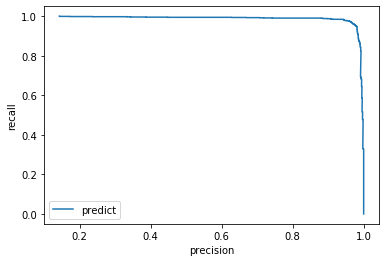

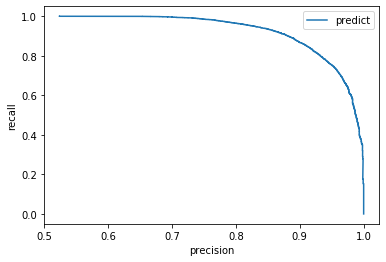

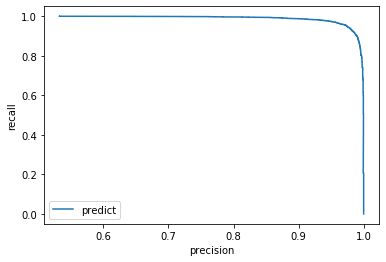

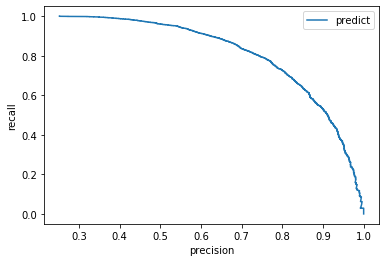

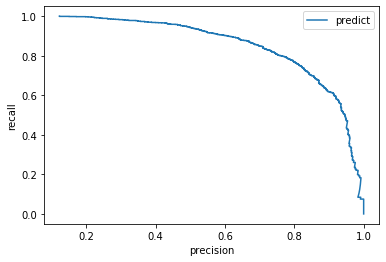

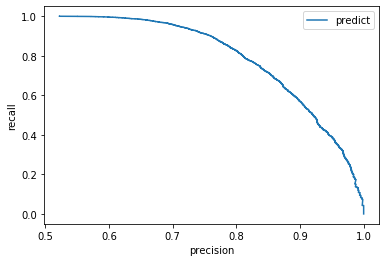

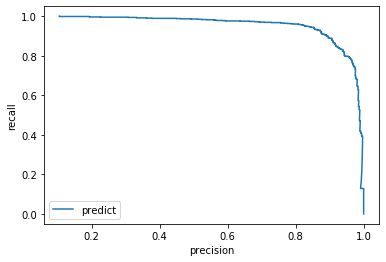

In [78]:
import matplotlib.pyplot as plt
#plt.plot(x,y,label="fact")
for i in range(7):
    plt.plot(pr[i][0],pr[i][1],label="predict")
    plt.title("")
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.legend()
    plt.savefig(fname="result.png",figsize=[10,10])
    plt.show()
    #"Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necklace", "Wearing_Necktie"

### 看逾期率

In [10]:
base_info=pd.read_csv(r'/home/tongqing.li/qianbao/xh_ncall_v2/data/face_picture_applied_data_base_info.csv')

In [11]:
base_info.columns

Index(['applied_id', 'uid', 'applied_date', 'os_type', 'active_month',
       'GBDT_age', 'gender', 'p1_max_consumed_withdraw_amount_sum',
       'bad1mon_status_ever', 'bad2mon_status_ever', 'bad3mon_status_ever',
       'bad4mon_status_ever', 'bad5mon_status_ever', 'bad6mon_status_ever'],
      dtype='object')

In [12]:
picturescore=pd.read_csv(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/data/picturescore.csv')

In [13]:
picturescore=picturescore.merge(base_info,on='applied_id',how='left')

In [9]:
picturescore

,Unnamed: 0,filename,applied_id,Eyeglasses,Heavy_Makeup,Male,Wearing_Earrings,Wearing_Necktie,Attractive,Wearing_Hat,...,active_month,GBDT_age,gender,p1_max_consumed_withdraw_amount_sum,bad1mon_status_ever,bad2mon_status_ever,bad3mon_status_ever,bad4mon_status_ever,bad5mon_status_ever,bad6mon_status_ever
0,0,52697741_04.jpg,52697741,0,0,1,0,0,0,0,...,2019-11-01,23.0,1.0,1386591.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,52697322_04.jpg,52697322,0,0,1,0,0,0,0,...,2019-11-01,28.0,1.0,1102400.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,52697214_04.jpg,52697214,0,0,1,0,0,0,0,...,2019-11-01,21.0,1.0,1400000.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,52697150_04.jpg,52697150,0,0,1,0,0,0,0,...,2019-11-01,44.0,1.0,1687160.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,52697100_04.jpg,52697100,0,0,0,0,0,0,0,...,2019-11-01,20.0,2.0,1388398.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,52697044_04.jpg,52697044,0,0,1,0,0,0,0,...,2019-11-01,26.0,1.0,887145.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,52696984_04.jpg,52696984,0,0,1,0,0,0,0,...,2019-11-01,47.0,1.0,1223913.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,52696934_04.jpg,52696934,0,0,1,0,0,0,0,...,2019-11-01,22.0,1.0,1799943.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,52696760_04.jpg,52696760,0,0,1,0,0,0,0,...,2019-11-01,29.0,1.0,602890.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,52696225_04.jpg,52696225,0,0,1,0,0,0,0,...,2019-11-01,21.0,1.0,1777347.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
picturescore.columns

Index(['Unnamed: 0', 'filename', 'applied_id', 'Eyeglasses', 'Heavy_Makeup',
       'Male', 'Wearing_Earrings', 'Wearing_Necktie', 'Attractive',
       'Wearing_Hat', 'uid', 'applied_date', 'os_type', 'active_month',
       'GBDT_age', 'gender', 'p1_max_consumed_withdraw_amount_sum',
       'bad1mon_status_ever', 'bad2mon_status_ever', 'bad3mon_status_ever',
       'bad4mon_status_ever', 'bad5mon_status_ever', 'bad6mon_status_ever'],
      dtype='object')

In [11]:
picturescore[['Eyeglasses', 'Heavy_Makeup',
       'Male', 'Wearing_Earrings', 'Wearing_Necktie', 'Attractive',
       'Wearing_Hat']].mean()

Eyeglasses          0.133932
Heavy_Makeup        0.000079
Male                0.785289
Wearing_Earrings    0.000061
Wearing_Necktie     0.000410
Attractive          0.000087
Wearing_Hat         0.003524
dtype: float64

In [12]:
picturescore.groupby([['Eyeglasses', 'Heavy_Makeup',
       'Male', 'Wearing_Earrings', 'Wearing_Necktie', 'Attractive',
       'Wearing_Hat']])['bad3mon_status_ever'].mean()

ValueError: Grouper and axis must be same length

In [14]:
picturescore.groupby(['Eyeglasses'])['bad3mon_status_ever'].mean()

Eyeglasses
0    0.053626
1    0.037126
Name: bad3mon_status_ever, dtype: float64

In [15]:
picturescore.groupby(['active_month','Eyeglasses'])['bad3mon_status_ever'].mean()

active_month  Eyeglasses
2019-03-01    0             0.062953
              1             0.044444
2019-04-01    0             0.062303
              1             0.044985
2019-05-01    0             0.048732
              1             0.026933
2019-06-01    0             0.034298
              1             0.024746
2019-07-01    0             0.038501
              1             0.036008
2019-08-01    0             0.053025
              1             0.035968
2019-09-01    0             0.055669
              1             0.038680
2019-10-01    0             0.058512
              1             0.040972
2019-11-01    0             0.056762
              1             0.045397
Name: bad3mon_status_ever, dtype: float64

In [59]:
picturescore.groupby(['active_month','Eyeglasses'])['bad4mon_status_ever'].mean()

active_month  Eyeglasses
2019-03-01    0             0.087383
              1             0.061905
2019-04-01    0             0.084088
              1             0.063222
2019-05-01    0             0.067966
              1             0.042572
2019-06-01    0             0.051382
              1             0.040609
2019-07-01    0             0.061635
              1             0.053498
2019-08-01    0             0.076935
              1             0.054711
2019-09-01    0             0.083668
              1             0.061372
2019-10-01    0             0.086255
              1             0.067175
2019-11-01    0             0.067619
              1             0.053594
Name: bad4mon_status_ever, dtype: float64

In [18]:
picturescore.groupby(['Wearing_Hat'])['bad3mon_status_ever'].mean()

Wearing_Hat
0    0.051441
1    0.044554
Name: bad3mon_status_ever, dtype: float64

In [19]:
picturescore.groupby(['Wearing_Hat'])['bad3mon_status_ever'].count()

Wearing_Hat
0    114229
1       404
Name: bad3mon_status_ever, dtype: int64

In [20]:
picturescore.groupby(['Wearing_Necktie'])['bad3mon_status_ever'].count()

Wearing_Necktie
0    114586
1        47
Name: bad3mon_status_ever, dtype: int64

In [27]:
picturescore.groupby(['Wearing_Necktie_flag'])['bad3mon_status_ever'].mean()

Wearing_Necktie_flag
0    0.051451
1    0.025641
Name: bad3mon_status_ever, dtype: float64

In [45]:
picturescore.groupby(['Wearing_Necktie_flag'])['bad3mon_status_ever'].mean()

Wearing_Necktie_flag
0    0.051440
1    0.041199
Name: bad3mon_status_ever, dtype: float64

In [21]:
picturescore.groupby(['Wearing_Necktie_flag'])['bad3mon_status_ever'].mean()

Wearing_Necktie
0    0.051420
1    0.042553
Name: bad3mon_status_ever, dtype: float64

In [23]:
picturescore.groupby(['Male'])['bad3mon_status_ever'].mean()

Male
0    0.046886
1    0.052655
Name: bad3mon_status_ever, dtype: float64

In [25]:
xh_npboc_ncall_v1_data=pull_table('''select * from mdl_score_v2 where version='xh_npboc_ncall_v1' ''')

NameError: name 'pull_table' is not defined

In [7]:
def pull_table(sql):
    cnxn =pymysql.connect(host='rc_riskv4_m.db.xiaoying.io',port=3306,user='tongqing.li', passwd='a@gYGzmPXS',db='risk_revo_v1',    charset='utf8mb4')
    cursor = cnxn.cursor()
    cursor.execute(sql)
    table = cursor.fetchall()
    desc = cursor.description    
    df = pd.DataFrame.from_records(list(table) ,columns=[list(desc)[i][0] for i in range(len(desc))])
    cursor.close()
    return df

In [8]:
import pymysql

In [22]:
xh_npboc_ncall_v1_data=pull_table('''select * from mdl_score_v2 where version='xh_npboc_ncall_v1' ''')

In [31]:
xh_npboc_ncall_v1_data

,applied_id,version,product_name,score,prob_score,risk_level,run_type,updated_at
0,29541783,xh_npboc_ncall_v1,xyqb,525,0.027051,47,4,2020-02-25 10:17:34
1,29561854,xh_npboc_ncall_v1,xyqb,516,0.036775,35,4,2020-02-25 10:17:34
2,29561943,xh_npboc_ncall_v1,xyqb,484,0.103281,7,4,2020-02-25 10:17:34
3,29561950,xh_npboc_ncall_v1,xyqb,501,0.060671,18,4,2020-02-25 10:17:34
4,29562072,xh_npboc_ncall_v1,xyqb,484,0.103683,7,4,2020-02-25 10:17:34
5,29562181,xh_npboc_ncall_v1,xyqb,494,0.074802,13,4,2020-02-25 10:17:34
6,29562263,xh_npboc_ncall_v1,xyqb,538,0.017695,66,4,2020-02-25 10:17:34
7,29562265,xh_npboc_ncall_v1,xyqb,485,0.101943,7,4,2020-02-25 10:17:34
8,29562443,xh_npboc_ncall_v1,xyqb,480,0.116098,5,4,2020-02-25 10:17:34
9,29562467,xh_npboc_ncall_v1,xyqb,487,0.093855,8,4,2020-02-25 10:17:34


In [214]:
picturescore=picturescore.merge(xh_npboc_ncall_v1_data[['applied_id','risk_level']],on='applied_id',how='left')

In [23]:
picturescore=picturescore.merge(xh_npboc_ncall_v1_data[['applied_id','prob_score']],on='applied_id',how='left')

In [16]:
picturescore_temp=picturescore1[['applied_id','Wearing_Necktie']]

In [18]:
picturescore_temp.columns=['applied_id','Wearing_Necktie_prob_score']

In [20]:
picturescore=picturescore.merge(picturescore_temp[['applied_id','Wearing_Necktie_prob_score']],on='applied_id',how='left')

In [24]:
picturescore['prob_score']=picturescore['prob_score'].astype(float)

In [42]:
picturescore['Wearing_Necktie_flag']=picturescore['Wearing_Necktie_prob_score'].map(lambda x:1 if(x>0.745) else 0)

In [44]:
picturescore['Wearing_Necktie_flag'].value_counts()

0    114366
1       267
Name: Wearing_Necktie_flag, dtype: int64

In [237]:
picturescore.to_csv(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/data/picturescore_new.csv',index=False)

In [217]:
picturescore_train=picturescore[picturescore['active_month'].map(lambda x: True if(x in  ['2019-03-01','2019-04-01','2020-05-01','2020-06-01']) else False)]

In [227]:
picturescore_oot=picturescore[picturescore['active_month'].map(lambda x: True if(x in  ['2019-07-01','2019-08-01','2019-09-01','2019-10-01']) else False)]

In [223]:
picturescore_oot=picturescore[picturescore['active_month'].map(lambda x: True if(x in  ['2019-07-01','2019-08-01']) else False)]

In [128]:
label='bad3mon_status_ever'

In [129]:
import statsmodels.api as sm
import numpy as np

In [215]:
step_wise_result=['risk_level','Eyeglasses']

In [185]:
picturescore_train[step_wise_result]

,prob_score,Eyeglasses
94157,0.025147,1
94158,0.033170,0
94161,0.024248,0
94162,0.022536,1
94163,0.084337,0
94166,0.006461,0
94168,0.037551,0
94170,0.043420,0
94173,0.022419,0
94174,0.127393,0


In [231]:
picturescore_train['risk_level']=picturescore_train['risk_level']/100

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [232]:
picturescore_oot['risk_level']=picturescore_oot['risk_level']/100

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [233]:
model =sm.Logit(picturescore_train[label], sm.add_constant(pd.DataFrame(picturescore_train[step_wise_result]))).fit(disp=0,method='newton')#返回训练好的模型

/home/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [234]:
model.params

const        -1.694998
risk_level   -3.564940
Eyeglasses   -0.325716
dtype: float64

In [172]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [164]:
feature_select_lgb_clf.fit(picturescore_train[step_wise_result],picturescore_train['bad3mon_status_ever'])

LGBMClassifier(colsample_bytree=1, max_bins=1024, max_depth=5,
               min_child_samples=500, min_child_weight=10, n_estimators=15,
               n_jobs=120, num_leaves=32, reg_alpha=0.1, reg_lambda=0.1,
               silent=-1, subsample=0.8, subsample_for_bin=1000000, verbose=-1)

In [165]:
step_wise_result

['prob_score', 'Eyeglasses']

In [ ]:
model.params

In [137]:
import math
def Gains_report(actual,preds,n_bins=10):
        actual_and_preds_df=pd.DataFrame()
        actual_and_preds_df['actual']=actual
        actual_and_preds_df['preds']=preds
        one_bin_number=math.ceil(actual_and_preds_df.shape[0]*1.0/n_bins)
        actual_and_preds_df['random_num']=range(actual_and_preds_df.shape[0])
        actual_and_preds_df=actual_and_preds_df.sort_values(by=['preds','random_num'],ascending=False)
        good=[]
        bad=[]
        Mean_Score=[]
        good_temp=0
        bad_temp=0
        binstemp=[]
        iindex= [ int(i * one_bin_number) for i in range(n_bins)]
        iindex.append((actual_and_preds_df.shape[0]))
        for i in range(len(iindex)-1):
            bad.append(actual_and_preds_df.iloc[iindex[i]:iindex[i+1]]['actual'].sum())
            good.append(actual_and_preds_df.iloc[iindex[i]:iindex[i+1]]['actual'].count()-actual_and_preds_df.iloc[iindex[i]:iindex[i+1]]['actual'].sum())
            Mean_Score.append(actual_and_preds_df.iloc[iindex[i]:iindex[i+1]]['preds'].mean())
            binstemp.append(actual_and_preds_df.iloc[iindex[i]]['preds'])
        binstemp.append(actual_and_preds_df.iloc[(actual_and_preds_df.shape[0]-1)]['preds'])
        n = len(binstemp) - 1
        actual=np.array(actual).reshape(-1,1)
        bad_actual = float(sum(actual)[0])
        good_actual = len(actual) - bad_actual
        #np.logical_and是逻辑与只是提供逻辑与的判断，不提供别的信息
        #n:0:-1是生成序列，步长为负1
        Total_No_Bad_percent=np.array(good)/good_actual*100
        Total_Bads_percent=np.array(bad)/bad_actual*100
        Total_No_Bad_percent_str=pd.Series(Total_No_Bad_percent).apply(lambda x: str(np.round(x,2))+'%' if(x!=0) else '0').values
        Total_Bads_percent_str=pd.Series(Total_Bads_percent).apply(lambda x: str(np.round(x,2))+'%' if(x!=0) else '0').values
        Cum_Total_Non_Bad=[sum(Total_No_Bad_percent[0:i+1]) for i in range(len(Total_No_Bad_percent))]
        Cum_Total_Bads=[sum(Total_Bads_percent[0:i+1]) for i in range(len(Total_Bads_percent))]
        Cum_Total_Bads_str=pd.Series(Cum_Total_Bads).apply(lambda x: str(np.round(x,2))+'%' if(x!=0) else '0').values
        Cum_Total_Non_Bad_str=pd.Series(Cum_Total_Non_Bad).apply(lambda x: str(np.round(x,2))+'%' if(x!=0) else '0').values
                                              
        Bads_vs_Non_Bad_KS=np.array(Cum_Total_Bads)-np.array(Cum_Total_Non_Bad)
        Bads_vs_Non_Bad_KS_str=pd.Series(Bads_vs_Non_Bad_KS).apply(lambda x: str(np.round(x,2))+'%' if(x!=0) else '0').values 
        total = [x[0]+x[1] for x in zip(bad, good)]#这里写的很好
        Interval_Bads_Rate=np.array(bad)*1.0/np.array(total)
        Interval_Bads_Rate=pd.Series(Interval_Bads_Rate).apply(lambda x: str(np.round(x*100,2))+'%' if(x!=0) else '0').values                         
        gains_report = pd.DataFrame(pd.np.zeros([len(binstemp)-1, 12]),index=range(1,len(binstemp)),columns=["# Total","Max Score","Min Score","Mean Score","# Non-Bad","% Total Non-Bad","Cum % Total Non-Bad","# Bads","% Total Bads","% Cum % Total Bads","Interval Bads Rate","Bads vs. Non-Bad K-S"])
        (gains_report["# Total"],gains_report["Max Score"],gains_report["Min Score"],gains_report["Mean Score"],gains_report["# Non-Bad"],gains_report["% Total Non-Bad"],gains_report['Cum % Total Non-Bad'],gains_report["# Bads"],gains_report["% Total Bads"],gains_report["% Cum % Total Bads"],gains_report["Interval Bads Rate"],gains_report["Bads vs. Non-Bad K-S"]) = (total,binstemp[0:-1],binstemp[1:],Mean_Score,good,Total_No_Bad_percent_str,Cum_Total_Non_Bad_str,bad,Total_Bads_percent_str,Cum_Total_Bads_str,Interval_Bads_Rate,Bads_vs_Non_Bad_KS_str)
        gains_report.reset_index(inplace=True)
        gains_report.rename(index=str, columns={"index": "Rank"},inplace=True)
        gains_report.loc[n_bins]={"Rank":'Total',"# Total":gains_report['# Total'].sum(),"Max Score":gains_report["Max Score"].max(),"Min Score":gains_report["Min Score"].min(),"Mean Score":np.mean(preds),"# Non-Bad":gains_report["# Non-Bad"].sum(),"% Total Non-Bad":str(np.round(Total_No_Bad_percent.sum(),2))+'%',"Cum % Total Non-Bad":"","# Bads":gains_report["# Bads"].sum(),"% Total Bads":str(np.round(Total_Bads_percent.sum(),2))+'%',"% Cum % Total Bads":"","Interval Bads Rate":str(np.round((len(preds) - good_actual)/len(preds)*100,2))+'%',"Bads vs. Non-Bad K-S":str(np.round(Bads_vs_Non_Bad_KS.max(),2))+'%'}
        return  gains_report

In [153]:
label='bad3mon_status_ever'

In [191]:
#feature_select_lgb_clf.predict_proba(attr_end_arr_end_df_test_data[step_wise_result])
Gains_report(picturescore_oot[label],feature_select_lgb_clf.predict_proba(picturescore_oot[step_wise_result])[:,1],n_bins=10)

,Rank,# Total,Max Score,Min Score,Mean Score,# Non-Bad,% Total Non-Bad,Cum % Total Non-Bad,# Bads,% Total Bads,% Cum % Total Bads,Interval Bads Rate,Bads vs. Non-Bad K-S
0,1,690.0,0.160565,0.157231,0.158091,667.0,10.06%,10.06%,23.0,8.75%,8.75%,3.33%,-1.31%
1,2,690.0,0.157231,0.157231,0.157231,653.0,9.85%,19.91%,37.0,14.07%,22.81%,5.36%,2.91%
2,3,690.0,0.157231,0.157231,0.157231,666.0,10.04%,29.95%,24.0,9.13%,31.94%,3.48%,1.99%
3,4,690.0,0.157231,0.157231,0.157231,671.0,10.12%,40.07%,19.0,7.22%,39.16%,2.75%,-0.91%
4,5,690.0,0.157231,0.157231,0.157231,656.0,9.89%,49.96%,34.0,12.93%,52.09%,4.93%,2.13%
5,6,690.0,0.157231,0.157231,0.157231,662.0,9.98%,59.95%,28.0,10.65%,62.74%,4.06%,2.79%
6,7,690.0,0.157231,0.157231,0.157231,664.0,10.01%,69.96%,26.0,9.89%,72.62%,3.77%,2.66%
7,8,690.0,0.157231,0.157231,0.157231,650.0,9.8%,79.76%,40.0,15.21%,87.83%,5.8%,8.07%
8,9,690.0,0.157231,0.125483,0.146015,664.0,10.01%,89.78%,26.0,9.89%,97.72%,3.77%,7.94%
9,10,684.0,0.125483,0.026442,0.092190,678.0,10.22%,100.0%,6.0,2.28%,100.0%,0.88%,0.0%


In [228]:
Gains_report(picturescore_oot[label],model.predict(sm.add_constant(pd.DataFrame(picturescore_oot[step_wise_result]))),n_bins=10)

/home/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Rank,# Total,Max Score,Min Score,Mean Score,# Non-Bad,% Total Non-Bad,Cum % Total Non-Bad,# Bads,% Total Bads,% Cum % Total Bads,Interval Bads Rate,Bads vs. Non-Bad K-S
0,1,5721.0,0.150505,0.077323,0.098306,5135.0,9.47%,9.47%,586.0,19.72%,19.72%,10.24%,10.26%
1,2,5721.0,0.077323,0.055421,0.065695,5266.0,9.71%,19.18%,455.0,15.31%,35.04%,7.95%,15.86%
2,3,5721.0,0.055421,0.043717,0.049272,5330.0,9.83%,29.01%,391.0,13.16%,48.2%,6.83%,19.19%
3,4,5721.0,0.043717,0.033230,0.038258,5372.0,9.91%,38.91%,349.0,11.75%,59.95%,6.1%,21.03%
4,5,5721.0,0.033230,0.026082,0.029844,5390.0,9.94%,48.85%,331.0,11.14%,71.09%,5.79%,22.24%
5,6,5721.0,0.026082,0.020440,0.023280,5481.0,10.11%,58.96%,240.0,8.08%,79.17%,4.2%,20.21%
6,7,5721.0,0.020440,0.015446,0.017860,5514.0,10.17%,69.13%,207.0,6.97%,86.13%,3.62%,17.01%
7,8,5721.0,0.015446,0.011255,0.013251,5546.0,10.23%,79.35%,175.0,5.89%,92.02%,3.06%,12.67%
8,9,5721.0,0.011255,0.007632,0.009411,5585.0,10.3%,89.65%,136.0,4.58%,96.6%,2.38%,6.95%
9,10,5714.0,0.007632,0.003737,0.006240,5613.0,10.35%,100.0%,101.0,3.4%,100.0%,1.77%,0


In [236]:
Gains_report(picturescore_oot[label],model.predict(sm.add_constant(pd.DataFrame(picturescore_oot[step_wise_result]))),n_bins=10)

/home/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Rank,# Total,Max Score,Min Score,Mean Score,# Non-Bad,% Total Non-Bad,Cum % Total Non-Bad,# Bads,% Total Bads,% Cum % Total Bads,Interval Bads Rate,Bads vs. Non-Bad K-S
0,1,5721.0,0.150505,0.077323,0.098306,5135.0,9.47%,9.47%,586.0,19.72%,19.72%,10.24%,10.26%
1,2,5721.0,0.077323,0.055421,0.065695,5266.0,9.71%,19.18%,455.0,15.31%,35.04%,7.95%,15.86%
2,3,5721.0,0.055421,0.043717,0.049272,5330.0,9.83%,29.01%,391.0,13.16%,48.2%,6.83%,19.19%
3,4,5721.0,0.043717,0.033230,0.038258,5372.0,9.91%,38.91%,349.0,11.75%,59.95%,6.1%,21.03%
4,5,5721.0,0.033230,0.026082,0.029844,5390.0,9.94%,48.85%,331.0,11.14%,71.09%,5.79%,22.24%
5,6,5721.0,0.026082,0.020440,0.023280,5481.0,10.11%,58.96%,240.0,8.08%,79.17%,4.2%,20.21%
6,7,5721.0,0.020440,0.015446,0.017860,5514.0,10.17%,69.13%,207.0,6.97%,86.13%,3.62%,17.01%
7,8,5721.0,0.015446,0.011255,0.013251,5546.0,10.23%,79.35%,175.0,5.89%,92.02%,3.06%,12.67%
8,9,5721.0,0.011255,0.007632,0.009411,5585.0,10.3%,89.65%,136.0,4.58%,96.6%,2.38%,6.95%
9,10,5714.0,0.007632,0.003737,0.006240,5613.0,10.35%,100.0%,101.0,3.4%,100.0%,1.77%,0


In [183]:
pd.DataFrame(picturescore_oot[step_wise_result])

,prob_score,Eyeglasses
64276,0.014587,0
64278,0.013840,0
64279,0.025524,1
64280,0.014715,0
64281,0.042493,0
64283,0.022245,0
64284,0.041367,0
64287,0.008634,0
64288,0.006481,0
64289,0.035141,0


In [206]:
picturescore_oot['new_score']=model.predict(sm.add_constant(pd.DataFrame(picturescore_oot[step_wise_result])))

/home/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [210]:
picturescore_oot.sort_values(['new_score','bad3mon_status_ever'],ascending=[False,False])[['new_score','bad3mon_status_ever']]

,new_score,bad3mon_status_ever
71118,0.043086,0.0
34292,0.038881,0.0
70884,0.038573,0.0
54508,0.036782,0.0
35015,0.036506,0.0
57824,0.036257,0.0
34269,0.036099,0.0
14863,0.035921,0.0
30764,0.035586,0.0
52131,0.035532,0.0


In [235]:
Gains_report(picturescore_oot[label],100-picturescore_oot['risk_level'],n_bins=10)

,Rank,# Total,Max Score,Min Score,Mean Score,# Non-Bad,% Total Non-Bad,Cum % Total Non-Bad,# Bads,% Total Bads,% Cum % Total Bads,Interval Bads Rate,Bads vs. Non-Bad K-S
0,1,5721.0,99.99,99.79,99.856742,5144.0,9.49%,9.49%,577.0,19.42%,19.42%,10.09%,9.94%
1,2,5721.0,99.79,99.69,99.738154,5265.0,9.71%,19.19%,456.0,15.35%,34.77%,7.97%,15.58%
2,3,5721.0,99.69,99.62,99.654289,5329.0,9.83%,29.02%,392.0,13.19%,47.96%,6.85%,18.94%
3,4,5721.0,99.62,99.55,99.580582,5368.0,9.9%,38.92%,353.0,11.88%,59.85%,6.17%,20.93%
4,5,5721.0,99.55,99.47,99.509589,5403.0,9.96%,48.88%,318.0,10.7%,70.55%,5.56%,21.67%
5,6,5721.0,99.47,99.40,99.438091,5475.0,10.1%,58.98%,246.0,8.28%,78.83%,4.3%,19.85%
6,7,5721.0,99.40,99.32,99.362944,5522.0,10.18%,69.16%,199.0,6.7%,85.53%,3.48%,16.37%
7,8,5721.0,99.32,99.23,99.277847,5532.0,10.2%,79.36%,189.0,6.36%,91.89%,3.3%,12.53%
8,9,5721.0,99.23,99.13,99.180138,5575.0,10.28%,89.64%,146.0,4.91%,96.8%,2.55%,7.16%
9,10,5714.0,99.13,99.00,99.065254,5619.0,10.36%,100.0%,95.0,3.2%,100.0%,1.66%,0


In [179]:
picturescore1=pd.read_csv(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/data/picture_score_probability.csv')

In [180]:
picturescore1.columns

Index(['Unnamed: 0', 'filename', 'applied_id', 'Eyeglasses', 'Heavy_Makeup',
       'Male', 'Wearing_Earrings', 'Wearing_Necktie', 'Attractive',
       'Wearing_Hat'],
      dtype='object')

In [5]:
picturescore1[picturescore1.sort_values(['Wearing_Necktie'],ascending=False)['Wearing_Necktie']>0.84].shape

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(156, 10)

In [4]:
picturescore1=pd.read_csv(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/data/picture_score_probability.csv')

In [15]:
picturescore1['Wearing_Necktie']

0         0.000709
1         0.001598
2         0.015387
3         0.020372
4         0.000313
5         0.011732
6         0.032821
7         0.014031
8         0.039018
9         0.007592
10        0.021889
11        0.000364
12        0.201374
13        0.013965
14        0.035406
15        0.000585
16        0.000971
17        0.050831
18        0.001367
19        0.000057
20        0.000424
21        0.000671
22        0.000502
23        0.000247
24        0.003158
25        0.004002
26        0.359802
27        0.000297
28        0.000201
29        0.007975
            ...   
114603    0.000287
114604    0.000391
114605    0.001943
114606    0.001614
114607    0.010104
114608    0.000407
114609    0.018090
114610    0.000580
114611    0.061328
114612    0.000673
114613    0.058547
114614    0.000957
114615    0.016746
114616    0.000320
114617    0.003663
114618    0.042843
114619    0.008924
114620    0.001380
114621    0.000184
114622    0.000297
114623    0.000230
114624    0.